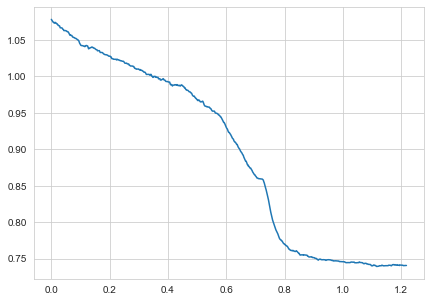

In [46]:
# First we will look at the data to see if it needs to be cropped

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
from lda.get_corrected_array import smooth

speed = 5  # The speed of the movement of the edge in um/s
N = 30
folder = r'D:\OneDrive - University of Victoria\Research\resolution\21-04-28_laser_mtf'
file = f'mtf6_405nm_75mA_5um_s_edge.txt'
img_name_append = '_closed_open_xray'

# Combine the folder and file for the full path
file = os.path.join(folder, file)

# Split the data into the time and current data
data = open(file).read().split()
times = np.array(data[1::2], dtype='float') / 1000 * (speed / 1000)  # Calculates the distances from the times and the speed
esf_full = np.array(data[2::2], dtype='float') * 1E9  # Converts from A to nA
# esf_full = medfilt(esf_full, kernel_size=N)[0:len(times)]
# This accepts windows: hanning, hamming, flat, bartlett, or blackman
# esf_full = smooth(esf_full, window_len=N, window='hamming')[0:len(times)]

# Plot the times vs. esf_full to see if the data should be cropped to calculate the lsf and mtf
fig = plt.figure(figsize=(7, 5))
sns.set_style('whitegrid')
plt.plot(times, esf_full)
plt.show()
# fig.savefig(os.path.join(folder, f'full_ESF{img_name_append}.png'), dpi=500)

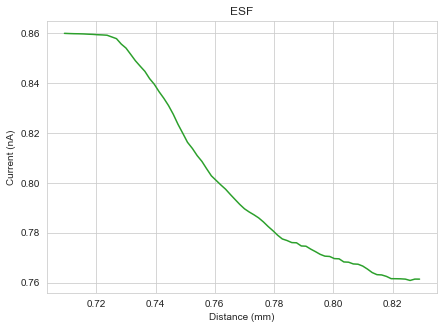

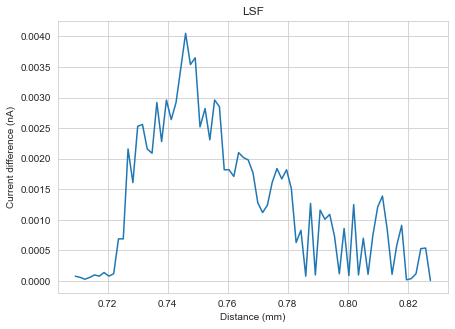

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Enter in the two time points that you found above
# low = 1.7
# high = 2.05

# Closed-open laser
# low = 0.75
# high = 0.89

# Open-closed laser
low = 0.71
high = 0.83

# Open-closed x-ray
# low = 0.2
# high = 1

# Closed-open x-ray
# low = 0.8
# high = 1.4


# Fit the ESF with a sigmoid
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

# This will get the appropriate index of those numbers to crop the ESF
low = (np.abs(times - low)).argmin()
high = (np.abs(times - high)).argmin()

esf = esf_full[low:high]
dist = times[low:high]

# p0 = [max(esf), np.median(dist), 1, min(dist)] # this is an mandatory initial guess
# popt, pcov = curve_fit(sigmoid, dist, esf, p0, method='dogbox')
#
# dist_fit = np.linspace(dist[0], dist[-1], 1000)
# esf_fit = sigmoid(dist_fit, *popt)

# Plot the cropped ESF data
sns.set_style('whitegrid')
fig = plt.figure(figsize=(7, 5))
plt.plot(dist, esf, color='C2')
# plt.plot(dist_fit, esf_fit)
plt.xlabel('Distance (mm)')
plt.ylabel('Current (nA)')
plt.title('ESF')
plt.show()
# fig.savefig(os.path.join(folder, f'ESF{img_name_append}.png'), dpi=500)

# Calculate the LSF from the derivative of the ESF
lsf = np.abs(np.diff(esf))
# lsf_fit = np.abs(np.diff(esf_fit))

# Plot the LSF
sns.set_style('whitegrid')
fig = plt.figure(figsize=(7, 5))
plt.plot(dist[0:len(lsf)], lsf)
# plt.plot(dist_fit[0:len(lsf_fit)], lsf_fit)
plt.xlabel('Distance (mm)')
plt.ylabel('Current difference (nA)')
plt.title('LSF')
plt.show()
# fig.savefig(os.path.join(folder, f'LSF{img_name_append}.png'), dpi=500)

[1.         0.98068806 0.96137612 0.94206417 0.92275223 0.90344029
 0.88412835 0.86481641 0.84550447 0.82619252 0.80688058 0.78756864
 0.7682567  0.74894476 0.72963281 0.71032087 0.69100893 0.67169699
 0.65238505 0.63307311 0.61376116 0.59444922 0.57513728 0.55582534
 0.5365134  0.51720145 0.49788951 0.47857757 0.46199688 0.45360994
 0.44522299 0.43683605 0.4284491  0.42006216 0.41167522 0.40328827
 0.39490133 0.38651439 0.37812744 0.3697405  0.36135356 0.35296661
 0.34457967 0.33619273 0.32780578 0.31941884 0.3110319  0.30264495
 0.29425801 0.28587106 0.27748412 0.26909718 0.26071023 0.25232329
 0.24393635 0.2355494  0.22918897 0.22485503 0.2205211  0.21618717
 0.21185324 0.20751931 0.20318537 0.19885144 0.19451751 0.19018358
 0.18584965 0.18151572 0.17718178 0.17284785 0.16851392 0.16417999
 0.15984606 0.15551212 0.15117819 0.14684426 0.14251033 0.1381764
 0.13384247 0.12950853 0.1251746  0.12084067 0.11650674 0.11217281
 0.10857222 0.10521609 0.10185996 0.09850382 0.09514769 0.09179

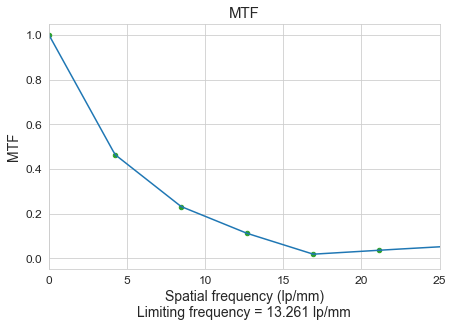

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

# Number of data points in the lsf
M = len(lsf)

# Sampling interval (distance between adjacent points in the ESF data)
dist_roll = np.roll(dist, -1)[:-1]
T = np.mean(dist_roll - dist[:-1])

# Get the frequencies to plot the MTF over
freq = np.linspace(0, 1 / T, M) / 2
freq = freq[0:int(M/2)]

# Calculate the MTF
mtf = fft(lsf)
mtf = np.absolute(mtf)
mtf = mtf[0:int(M/2)]
mtf = np.divide(mtf, np.max(mtf))  # Normalize to 1

# Fit the data
def func(x, a, b):
    return a * np.exp(-b * x)

freq_fit = np.linspace(0, freq[-1], 1000)

# popt, pcov = curve_fit(func, freq, mtf)

# mtf_fit = func(freq_fit, *popt)
cs = interp1d(freq, mtf)
mtf_fit = cs(freq_fit)

# Find the index of the fitted MTF that is closest to 20%
print(mtf_fit[0:100])
idx = np.abs(mtf_fit[0:100] - 0.1).argmin()
print(f'Limiting resolution: {freq_fit[idx]:0.3f} lp/mm, {1/(2*freq_fit[idx]):0.4f} mm')

sns.set_style('whitegrid')
fig = plt.figure(figsize=(7, 5))
plt.plot(freq_fit, mtf_fit)
plt.scatter(freq, mtf, s=20, color='C2')
plt.title(rf'MTF', fontsize=15)
plt.xlabel(f'Spatial frequency (lp/mm)\nLimiting frequency = {freq_fit[idx]:.3f} lp/mm', fontsize=14)
plt.ylabel('MTF', fontsize=14)
plt.tick_params(labelsize=12)
plt.xlim([0, 25])
plt.subplots_adjust(bottom=0.2)
plt.show()
# fig.savefig(os.path.join(folder, f'MTF{img_name_append}.png'), dpi=500)
# np.save(os.path.join(folder, f'MTF_data.npy')

In [49]:
# csv_array = np.zeros([len(times)+1, 2])
# csv_array[1:, 0] = times
# csv_array[1:, 1] = esf_full
# csv_array = csv_array.astype(str)
#
# leg = ['Distance (mm)', 'ESF']
# csv_array[0] = leg
#
# np.savetxt(os.path.join(folder, f'full_esf{img_name_append}.csv'), csv_array, delimiter=',', fmt='%s')
#
# csv_array = np.zeros([len(dist)+1, 2])
# csv_array[1:, 0] = dist
# csv_array[1:, 1] = esf
# csv_array = csv_array.astype(str)
#
# leg = ['Distance (mm)', 'ESF']
# csv_array[0] = leg
#
# np.savetxt(os.path.join(folder, f'cropped_esf{img_name_append}.csv'), csv_array, delimiter=',', fmt='%s')
#
# csv_array = np.zeros([len(freq)+1, 2])
# csv_array[1:, 0] = freq
# csv_array[1:, 1] = mtf
# csv_array = csv_array.astype(str)
#
# leg = ['Frequency (lp/mm)', 'MTF']
# csv_array[0] = leg
#
# np.savetxt(os.path.join(folder, f'raw_mtf{img_name_append}.csv'), csv_array, delimiter=',', fmt='%s')
#
# csv_array = np.zeros([len(freq_fit)+1, 2])
# csv_array[1:, 0] = freq_fit
# csv_array[1:, 1] = mtf_fit
# csv_array = csv_array.astype(str)
#
# leg = ['Frequency (lp/mm)', 'MTF']
# csv_array[0] = leg
#
# np.savetxt(os.path.join(folder, f'mtf_fit{img_name_append}.csv'), csv_array, delimiter=',', fmt='%s')